检测到PyTorch版本: 2.5.1
MPS后端可用，尝试初始化...
✓ MPS设备初始化成功: mps
mps
It: 0, Loss: 1.369e+00, Y0: -0.548, Time: 0.07, Learning Rate: 1.000e-03
It: 100, Loss: 7.402e-01, Y0: 0.154, Time: 7.13, Learning Rate: 1.000e-03
It: 200, Loss: 5.040e-01, Y0: 0.110, Time: 6.58, Learning Rate: 1.000e-03
It: 300, Loss: 5.242e-01, Y0: 0.124, Time: 7.37, Learning Rate: 1.000e-03
It: 400, Loss: 6.008e-01, Y0: -0.067, Time: 6.67, Learning Rate: 1.000e-03
It: 500, Loss: 5.766e-01, Y0: -0.105, Time: 7.20, Learning Rate: 1.000e-03
It: 600, Loss: 4.306e-01, Y0: 0.308, Time: 7.02, Learning Rate: 1.000e-03
It: 700, Loss: 3.599e-01, Y0: -0.042, Time: 6.75, Learning Rate: 1.000e-03
It: 800, Loss: 7.440e-02, Y0: -0.002, Time: 7.05, Learning Rate: 1.000e-03
It: 900, Loss: 8.929e-02, Y0: 0.107, Time: 6.74, Learning Rate: 1.000e-03
It: 1000, Loss: 3.298e-02, Y0: 0.125, Time: 6.81, Learning Rate: 1.000e-03
It: 1100, Loss: 9.141e-01, Y0: -0.036, Time: 6.90, Learning Rate: 1.000e-03
It: 1200, Loss: 1.744e-01, Y0: 0.146, Time: 6.9

/var/folders/2d/332l1jtn17l_9rn575r5q36r0000gn/T/ipykernel_79555/340514793.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j], deltas[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)


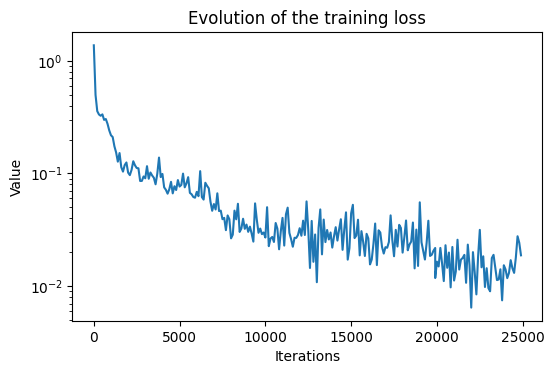

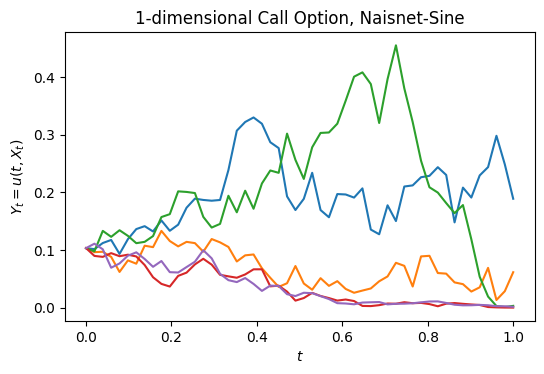

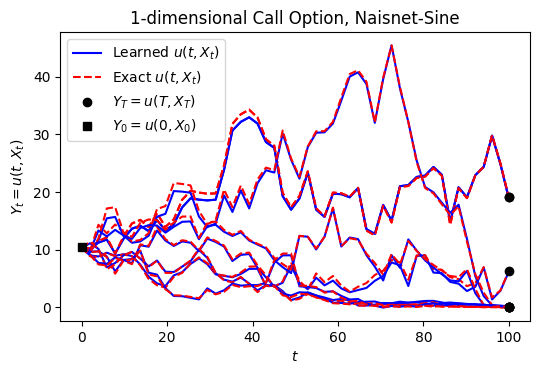

In [5]:
import sys
import os

from cqf_utils import set_seed
sys.path.append(os.path.abspath("Algorithms/"))
sys.path.append(os.path.abspath("models/"))
#%%
from cqf_FBSNNs import *
from cqf_CallOption import *
#%%
import numpy as np
import torch
import matplotlib.pyplot as plt
import time

M = 1 # 轨迹数量（批量大小） number of trajectories (batch size)
N = 50  #  时间快照数量 number of time snapshots
D = 1 # 维度数 number of dimensions
Mm = N ** (1/5) # 计算Mm为N的1/5次方

layers = [D + 1] + 4 * [256] + [1] #  定义神经网络层结构

Xi = np.array([1.0] * D)[None, :]  # 创建初始条件数组
T = 1.0 # 设置时间参数

"Available architectures"
mode = "Naisnet"  #  可用选项：FC 和 Naisnet  | FC and Naisnet are available
activation = "Sine"  # 激活函数：Sine、ReLU 和 Tanh | Sine, ReLU and Tanh are available
model = CallOption(Xi, T, M, N, D, Mm, layers, mode, activation)

n_iter = 2 * 10 ** 4 # 训练迭代次数
lr = 1e-3 # 学习率
#%%
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")
#%%
# model.load_model("models/CallOption4-256XVAPaper.pth")
#%%
n_iter = 51 * 10 ** 2
lr = 1e-5
#%%
tot = time.time()
print(model.device)
graph = model.train(n_iter, lr)
print("total time:", time.time() - tot, "s")
#%%

set_seed(37)
t_test, W_test = model.fetch_minibatch()
X_pred, Y_pred = model.predict(Xi, t_test, W_test)

if type(t_test).__module__ != 'numpy':
    t_test = t_test.cpu().numpy()
if type(X_pred).__module__ != 'numpy':
    X_pred = X_pred.cpu().detach().numpy()
if type(Y_pred).__module__ != 'numpy':
    Y_pred = Y_pred.cpu().detach().numpy()

for i in range(15):
    t_test_i, W_test_i = model.fetch_minibatch()
    X_pred_i, Y_pred_i = model.predict(Xi, t_test_i, W_test_i)
    if type(X_pred_i).__module__ != 'numpy':
        X_pred_i = X_pred_i.cpu().detach().numpy()
    if type(Y_pred_i).__module__ != 'numpy':
        Y_pred_i = Y_pred_i.cpu().detach().numpy()
    if type(t_test_i).__module__ != 'numpy':
        t_test_i = t_test_i.cpu().numpy()
    t_test = np.concatenate((t_test, t_test_i), axis=0)
    X_pred = np.concatenate((X_pred, X_pred_i), axis=0)
    Y_pred = np.concatenate((Y_pred, Y_pred_i), axis=0)
X_pred = X_pred[:500, :]
# %%
from scipy.stats import multivariate_normal as normal

# %%
X_preds = X_pred[:, :, 0]


# %%
def black_scholes_call(S, K, T, r, sigma, q=0):
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = (S * np.exp(-q * T) * normal.cdf(d1)) - (K * np.exp(-r * T) * normal.cdf(d2))
    delta = normal.cdf(d1)
    return call_price, delta


def calculate_option_prices(X_pred, time_array, K, r, sigma, T, q=0):
    rows, cols = X_pred.shape
    option_prices = np.zeros((rows, cols))
    deltas = np.zeros((rows, cols))

    for i in range(rows):
        for j in range(cols):
            S = X_pred[i, j]
            t = time_array[j]
            time_to_maturity = T - t
            if time_to_maturity > 0:
                option_prices[i, j], deltas[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)
            else:
                option_prices[i, j] = max(S - K, 0)
                if S > K:
                    deltas[i, j] = 1
                elif S == K:
                    deltas[i, j] = 0.5
                else:
                    deltas[i, j] = 0

    return option_prices, deltas


# Given parameters
K = 1.0  # Strike price
r = 0.01  # Risk-free interest rate
sigma = 0.25  # Volatility
q = 0  # Dividend yield (assuming none)
T = 1  # Expiry time in years

Y_test, Z_test = calculate_option_prices(X_preds, t_test[0], K, r, sigma, T, q)

errors = (Y_test[:500] - Y_pred[:500,:,0])**2
errors.mean(), errors.std()

np.sqrt(errors.mean())

graph = model.iteration, model.training_loss
#%%
def figsize(scale, nplots = 1):
    fig_width_pt = 438.17227
    inches_per_pt = 1.0/72.27
    golden_mean = (np.sqrt(5.0)-1.0)/2.0
    fig_width = fig_width_pt*inches_per_pt*scale
    fig_height = nplots*fig_width*golden_mean
    fig_size = [fig_width,fig_height]
    return fig_size
#%%
plt.figure(figsize=figsize(1.0))
plt.plot(graph[0], graph[1])
plt.xlabel('Iterations')
plt.ylabel('Value')
plt.yscale("log")
plt.title('Evolution of the training loss')
samples = 5
# plt.savefig('Figures/CallOption1DLoss.pdf')
plt.figure(figsize=figsize(1.0))
plt.plot(t_test[0:1, :, 0].T, Y_pred[0:1, :, 0].T)

plt.plot(t_test[1:samples, :, 0].T, Y_pred[1:samples, :, 0].T)

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.title(str(D) + '-dimensional Call Option, ' + model.mode + "-" + model.activation)

plt.show()

plt.figure(figsize=figsize(1.0))
plt.plot(t_test[0] * 100, Y_pred[0] * 100, 'b', label='Learned $u(t,X_t)$')
plt.plot(t_test[0] * 100, Y_test[0] * 100, 'r--', label='Exact $u(t,X_t)$')
plt.plot(t_test[0, -1] * 100, Y_test[0, -1] * 100, 'ko', label='$Y_T = u(T,X_T)$')
for i in range(7):
    plt.plot(t_test[i] * 100, Y_pred[i] * 100, 'b')
    plt.plot(t_test[i] * 100, Y_test[i] * 100, 'r--')
    plt.plot(t_test[i, -1] * 100, Y_test[i, -1] * 100, 'ko')
plt.plot([0], Y_test[0,0] * 100, 'ks', label='$Y_0 = u(0,X_0)$')
plt.title(str(D) + '-dimensional Call Option, ' + model.mode + "-" + model.activation)
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t,X_t)$')
plt.savefig("CallOption1DPreds.png")
# plt.show()

In [ ]:
检测到PyTorch版本: 2.5.1
MPS后端可用，尝试初始化...
✓ MPS设备初始化成功: mps
mps
It: 0, Loss: 1.369e+00, Y0: -0.548, Time: 0.07, Learning Rate: 1.000e-03
It: 100, Loss: 7.402e-01, Y0: 0.154, Time: 7.13, Learning Rate: 1.000e-03
It: 200, Loss: 5.040e-01, Y0: 0.110, Time: 6.58, Learning Rate: 1.000e-03
It: 300, Loss: 5.242e-01, Y0: 0.124, Time: 7.37, Learning Rate: 1.000e-03
It: 400, Loss: 6.008e-01, Y0: -0.067, Time: 6.67, Learning Rate: 1.000e-03
It: 500, Loss: 5.766e-01, Y0: -0.105, Time: 7.20, Learning Rate: 1.000e-03
It: 600, Loss: 4.306e-01, Y0: 0.308, Time: 7.02, Learning Rate: 1.000e-03
It: 700, Loss: 3.599e-01, Y0: -0.042, Time: 6.75, Learning Rate: 1.000e-03
It: 800, Loss: 7.440e-02, Y0: -0.002, Time: 7.05, Learning Rate: 1.000e-03
It: 900, Loss: 8.929e-02, Y0: 0.107, Time: 6.74, Learning Rate: 1.000e-03
It: 1000, Loss: 3.298e-02, Y0: 0.125, Time: 6.81, Learning Rate: 1.000e-03
It: 1100, Loss: 9.141e-01, Y0: -0.036, Time: 6.90, Learning Rate: 1.000e-03
It: 1200, Loss: 1.744e-01, Y0: 0.146, Time: 6.95, Learning Rate: 1.000e-03
It: 1300, Loss: 1.306e-01, Y0: 0.378, Time: 7.27, Learning Rate: 1.000e-03
It: 1400, Loss: 1.664e-02, Y0: 0.101, Time: 7.16, Learning Rate: 1.000e-03
It: 1500, Loss: 1.333e-01, Y0: 0.066, Time: 6.75, Learning Rate: 1.000e-03
It: 1600, Loss: 2.225e-02, Y0: 0.289, Time: 6.51, Learning Rate: 1.000e-03
It: 1700, Loss: 3.001e-03, Y0: 0.098, Time: 6.58, Learning Rate: 1.000e-03
It: 1800, Loss: 1.905e-01, Y0: 0.092, Time: 6.57, Learning Rate: 1.000e-03
It: 1900, Loss: 5.087e-01, Y0: 0.155, Time: 6.55, Learning Rate: 1.000e-03
It: 2000, Loss: 2.735e-01, Y0: 0.003, Time: 6.61, Learning Rate: 1.000e-03
It: 2100, Loss: 4.550e-03, Y0: 0.031, Time: 6.64, Learning Rate: 1.000e-03
It: 2200, Loss: 5.611e-02, Y0: 0.126, Time: 6.83, Learning Rate: 1.000e-03
It: 2300, Loss: 3.903e-01, Y0: 0.084, Time: 6.61, Learning Rate: 1.000e-03
It: 2400, Loss: 3.247e-02, Y0: 0.125, Time: 6.51, Learning Rate: 1.000e-03
It: 2500, Loss: 1.438e-01, Y0: 0.092, Time: 6.56, Learning Rate: 1.000e-03
It: 2600, Loss: 1.126e-01, Y0: 0.104, Time: 6.54, Learning Rate: 1.000e-03
It: 2700, Loss: 9.587e-02, Y0: 0.081, Time: 6.61, Learning Rate: 1.000e-03
It: 2800, Loss: 6.010e-02, Y0: 0.141, Time: 6.49, Learning Rate: 1.000e-03
It: 2900, Loss: 3.971e-01, Y0: 0.130, Time: 6.56, Learning Rate: 1.000e-03
It: 3000, Loss: 2.351e-01, Y0: 0.119, Time: 6.61, Learning Rate: 1.000e-03
It: 3100, Loss: 3.502e-02, Y0: 0.130, Time: 6.56, Learning Rate: 1.000e-03
It: 3200, Loss: 8.453e-03, Y0: 0.107, Time: 6.88, Learning Rate: 1.000e-03
It: 3300, Loss: 6.669e-03, Y0: 0.138, Time: 6.65, Learning Rate: 1.000e-03
It: 3400, Loss: 2.550e-01, Y0: 0.065, Time: 6.70, Learning Rate: 1.000e-03
It: 3500, Loss: 1.289e-01, Y0: 0.101, Time: 7.11, Learning Rate: 1.000e-03
It: 3600, Loss: 2.474e-02, Y0: 0.111, Time: 6.62, Learning Rate: 1.000e-03
It: 3700, Loss: 1.198e-01, Y0: 0.135, Time: 6.90, Learning Rate: 1.000e-03
It: 3800, Loss: 2.369e-01, Y0: 0.088, Time: 6.41, Learning Rate: 1.000e-03
It: 3900, Loss: 2.284e-02, Y0: 0.097, Time: 6.54, Learning Rate: 1.000e-03
It: 4000, Loss: 1.318e-02, Y0: 0.095, Time: 6.86, Learning Rate: 1.000e-03
It: 4100, Loss: 4.560e-02, Y0: 0.124, Time: 9.13, Learning Rate: 1.000e-03
It: 4200, Loss: 1.385e-02, Y0: 0.114, Time: 9.64, Learning Rate: 1.000e-03
It: 4300, Loss: 2.124e-02, Y0: 0.114, Time: 10.04, Learning Rate: 1.000e-03
It: 4400, Loss: 1.347e-01, Y0: 0.073, Time: 9.16, Learning Rate: 1.000e-03
It: 4500, Loss: 8.575e-02, Y0: 0.166, Time: 9.07, Learning Rate: 1.000e-03
It: 4600, Loss: 9.583e-03, Y0: 0.063, Time: 9.48, Learning Rate: 1.000e-03
It: 4700, Loss: 1.513e-02, Y0: 0.103, Time: 9.09, Learning Rate: 1.000e-03
It: 4800, Loss: 2.840e-03, Y0: 0.102, Time: 9.85, Learning Rate: 1.000e-03
It: 4900, Loss: 8.938e-02, Y0: 0.104, Time: 9.33, Learning Rate: 1.000e-03
It: 5000, Loss: 1.596e-01, Y0: 0.124, Time: 9.54, Learning Rate: 1.000e-03
It: 5100, Loss: 9.531e-03, Y0: 0.162, Time: 9.28, Learning Rate: 1.000e-03
It: 5200, Loss: 2.427e-01, Y0: 0.099, Time: 9.61, Learning Rate: 1.000e-03
It: 5300, Loss: 1.138e-02, Y0: 0.122, Time: 10.76, Learning Rate: 1.000e-03
It: 5400, Loss: 1.659e-02, Y0: 0.105, Time: 10.20, Learning Rate: 1.000e-03
It: 5500, Loss: 1.460e-01, Y0: 0.098, Time: 9.87, Learning Rate: 1.000e-03
It: 5600, Loss: 1.809e-03, Y0: 0.100, Time: 11.98, Learning Rate: 1.000e-03
It: 5700, Loss: 1.100e-01, Y0: 0.109, Time: 12.27, Learning Rate: 1.000e-03
It: 5800, Loss: 7.090e-02, Y0: 0.116, Time: 10.64, Learning Rate: 1.000e-03
It: 5900, Loss: 3.224e-03, Y0: 0.110, Time: 9.97, Learning Rate: 1.000e-03
It: 6000, Loss: 1.297e-01, Y0: 0.126, Time: 9.89, Learning Rate: 1.000e-03
It: 6100, Loss: 5.394e-02, Y0: 0.127, Time: 10.17, Learning Rate: 1.000e-03
It: 6200, Loss: 1.835e-03, Y0: 0.119, Time: 9.66, Learning Rate: 1.000e-03
It: 6300, Loss: 1.743e-02, Y0: 0.094, Time: 9.42, Learning Rate: 1.000e-03
It: 6400, Loss: 4.275e-02, Y0: 0.071, Time: 9.59, Learning Rate: 1.000e-03
It: 6500, Loss: 3.863e-02, Y0: 0.094, Time: 9.26, Learning Rate: 1.000e-03
It: 6600, Loss: 1.074e-02, Y0: 0.102, Time: 9.39, Learning Rate: 1.000e-03
It: 6700, Loss: 7.485e-03, Y0: 0.074, Time: 9.19, Learning Rate: 1.000e-03
It: 6800, Loss: 1.967e-03, Y0: 0.123, Time: 9.03, Learning Rate: 1.000e-03
It: 6900, Loss: 9.326e-03, Y0: 0.104, Time: 9.34, Learning Rate: 1.000e-03
It: 7000, Loss: 6.887e-03, Y0: 0.085, Time: 9.46, Learning Rate: 1.000e-03
It: 7100, Loss: 2.770e-02, Y0: 0.072, Time: 9.58, Learning Rate: 1.000e-03
It: 7200, Loss: 3.183e-01, Y0: 0.092, Time: 9.45, Learning Rate: 1.000e-03
It: 7300, Loss: 1.323e-01, Y0: 0.099, Time: 9.50, Learning Rate: 1.000e-03
It: 7400, Loss: 3.739e-03, Y0: 0.164, Time: 9.56, Learning Rate: 1.000e-03
It: 7500, Loss: 1.742e-03, Y0: 0.103, Time: 9.46, Learning Rate: 1.000e-03
It: 7600, Loss: 3.593e-03, Y0: 0.140, Time: 9.32, Learning Rate: 1.000e-03
It: 7700, Loss: 4.801e-02, Y0: 0.108, Time: 9.59, Learning Rate: 1.000e-03
It: 7800, Loss: 4.512e-03, Y0: 0.076, Time: 9.09, Learning Rate: 1.000e-03
It: 7900, Loss: 1.588e-02, Y0: 0.061, Time: 9.16, Learning Rate: 1.000e-03
It: 8000, Loss: 2.052e-03, Y0: 0.099, Time: 9.48, Learning Rate: 1.000e-03
It: 8100, Loss: 1.563e-03, Y0: 0.088, Time: 17.93, Learning Rate: 1.000e-03
It: 8200, Loss: 4.910e-04, Y0: 0.097, Time: 19.36, Learning Rate: 1.000e-03
It: 8300, Loss: 1.341e-02, Y0: 0.093, Time: 18.43, Learning Rate: 1.000e-03
It: 8400, Loss: 1.136e-01, Y0: 0.141, Time: 18.65, Learning Rate: 1.000e-03
It: 8500, Loss: 2.659e-03, Y0: 0.113, Time: 17.61, Learning Rate: 1.000e-03
It: 8600, Loss: 4.130e-01, Y0: 0.083, Time: 18.08, Learning Rate: 1.000e-03
It: 8700, Loss: 9.761e-04, Y0: 0.134, Time: 18.07, Learning Rate: 1.000e-03
It: 8800, Loss: 7.589e-02, Y0: 0.108, Time: 18.25, Learning Rate: 1.000e-03
It: 8900, Loss: 1.743e-03, Y0: 0.135, Time: 19.69, Learning Rate: 1.000e-03
It: 9000, Loss: 4.071e-03, Y0: 0.096, Time: 18.63, Learning Rate: 1.000e-03
It: 9100, Loss: 1.118e-02, Y0: 0.106, Time: 17.94, Learning Rate: 1.000e-03
It: 9200, Loss: 3.775e-02, Y0: 0.101, Time: 18.03, Learning Rate: 1.000e-03
It: 9300, Loss: 2.222e-03, Y0: 0.103, Time: 18.10, Learning Rate: 1.000e-03
It: 9400, Loss: 1.256e-02, Y0: 0.124, Time: 19.09, Learning Rate: 1.000e-03
It: 9500, Loss: 1.211e-01, Y0: 0.127, Time: 18.38, Learning Rate: 1.000e-03
It: 9600, Loss: 1.915e-01, Y0: 0.113, Time: 17.70, Learning Rate: 1.000e-03
It: 9700, Loss: 1.120e-02, Y0: 0.111, Time: 18.51, Learning Rate: 1.000e-03
It: 9800, Loss: 1.186e-03, Y0: 0.111, Time: 19.16, Learning Rate: 1.000e-03
It: 9900, Loss: 2.643e-03, Y0: 0.127, Time: 18.10, Learning Rate: 1.000e-03
It: 10000, Loss: 4.074e-03, Y0: 0.088, Time: 18.71, Learning Rate: 1.000e-03
It: 10100, Loss: 3.213e-04, Y0: 0.157, Time: 18.60, Learning Rate: 1.000e-03
It: 10200, Loss: 8.786e-04, Y0: 0.114, Time: 19.49, Learning Rate: 1.000e-03
It: 10300, Loss: 1.466e-02, Y0: 0.075, Time: 19.69, Learning Rate: 1.000e-03
It: 10400, Loss: 2.614e-03, Y0: 0.087, Time: 18.97, Learning Rate: 1.000e-03
It: 10500, Loss: 1.906e-03, Y0: 0.074, Time: 19.14, Learning Rate: 1.000e-03
It: 10600, Loss: 1.281e-03, Y0: 0.116, Time: 18.58, Learning Rate: 1.000e-03
It: 10700, Loss: 4.914e-04, Y0: 0.117, Time: 19.19, Learning Rate: 1.000e-03
It: 10800, Loss: 5.570e-04, Y0: 0.115, Time: 18.60, Learning Rate: 1.000e-03
It: 10900, Loss: 6.086e-03, Y0: 0.106, Time: 17.15, Learning Rate: 1.000e-03
It: 11000, Loss: 4.569e-01, Y0: 0.109, Time: 19.34, Learning Rate: 1.000e-03
It: 11100, Loss: 7.154e-03, Y0: 0.086, Time: 19.79, Learning Rate: 1.000e-03
It: 11200, Loss: 7.575e-04, Y0: 0.107, Time: 19.52, Learning Rate: 1.000e-03
It: 11300, Loss: 1.071e-01, Y0: 0.112, Time: 19.36, Learning Rate: 1.000e-03
It: 11400, Loss: 1.127e-02, Y0: 0.107, Time: 17.98, Learning Rate: 1.000e-03
It: 11500, Loss: 1.279e-02, Y0: 0.081, Time: 18.71, Learning Rate: 1.000e-03
It: 11600, Loss: 9.295e-04, Y0: 0.119, Time: 20.18, Learning Rate: 1.000e-03
It: 11700, Loss: 1.174e-03, Y0: 0.092, Time: 18.00, Learning Rate: 1.000e-03
It: 11800, Loss: 9.681e-03, Y0: 0.133, Time: 18.35, Learning Rate: 1.000e-03
It: 11900, Loss: 1.229e-01, Y0: 0.120, Time: 17.82, Learning Rate: 1.000e-03
It: 12000, Loss: 1.658e-02, Y0: 0.115, Time: 17.92, Learning Rate: 1.000e-03
It: 12100, Loss: 4.954e-03, Y0: 0.136, Time: 39.96, Learning Rate: 1.000e-03
It: 12200, Loss: 2.796e-02, Y0: 0.112, Time: 38.28, Learning Rate: 1.000e-03
It: 12300, Loss: 1.349e-04, Y0: 0.100, Time: 37.08, Learning Rate: 1.000e-03
It: 12400, Loss: 1.424e-03, Y0: 0.092, Time: 35.40, Learning Rate: 1.000e-03
It: 12500, Loss: 1.019e-02, Y0: 0.088, Time: 35.32, Learning Rate: 1.000e-03
It: 12600, Loss: 2.030e-04, Y0: 0.089, Time: 39.61, Learning Rate: 1.000e-03
It: 12700, Loss: 4.488e-02, Y0: 0.090, Time: 36.35, Learning Rate: 1.000e-03
It: 12800, Loss: 1.705e-03, Y0: 0.135, Time: 36.57, Learning Rate: 1.000e-03
It: 12900, Loss: 1.471e-03, Y0: 0.105, Time: 37.52, Learning Rate: 1.000e-03
It: 13000, Loss: 4.210e-03, Y0: 0.096, Time: 35.43, Learning Rate: 1.000e-03
It: 13100, Loss: 1.220e-02, Y0: 0.086, Time: 36.03, Learning Rate: 1.000e-03
It: 13200, Loss: 2.691e-01, Y0: 0.074, Time: 36.09, Learning Rate: 1.000e-03
It: 13300, Loss: 6.660e-04, Y0: 0.101, Time: 36.15, Learning Rate: 1.000e-03
It: 13400, Loss: 3.385e-03, Y0: 0.110, Time: 36.00, Learning Rate: 1.000e-03
It: 13500, Loss: 9.836e-02, Y0: 0.119, Time: 36.52, Learning Rate: 1.000e-03
It: 13600, Loss: 2.088e-02, Y0: 0.104, Time: 36.76, Learning Rate: 1.000e-03
It: 13700, Loss: 1.759e-02, Y0: 0.110, Time: 35.79, Learning Rate: 1.000e-03
It: 13800, Loss: 4.594e-03, Y0: 0.102, Time: 36.74, Learning Rate: 1.000e-03
It: 13900, Loss: 2.450e-01, Y0: 0.102, Time: 37.52, Learning Rate: 1.000e-03
It: 14000, Loss: 8.031e-04, Y0: 0.107, Time: 37.36, Learning Rate: 1.000e-03
It: 14100, Loss: 1.811e-03, Y0: 0.107, Time: 34.92, Learning Rate: 1.000e-03
It: 14200, Loss: 1.172e-01, Y0: 0.111, Time: 34.96, Learning Rate: 1.000e-03
It: 14300, Loss: 1.188e-03, Y0: 0.088, Time: 36.54, Learning Rate: 1.000e-03
It: 14400, Loss: 1.641e-01, Y0: 0.156, Time: 36.00, Learning Rate: 1.000e-03
It: 14500, Loss: 2.091e-03, Y0: 0.120, Time: 35.24, Learning Rate: 1.000e-03
It: 14600, Loss: 8.921e-04, Y0: 0.105, Time: 35.42, Learning Rate: 1.000e-03
It: 14700, Loss: 2.238e-03, Y0: 0.107, Time: 35.55, Learning Rate: 1.000e-03
It: 14800, Loss: 1.501e-03, Y0: 0.104, Time: 35.87, Learning Rate: 1.000e-03
It: 14900, Loss: 2.622e-04, Y0: 0.098, Time: 35.54, Learning Rate: 1.000e-03
It: 15000, Loss: 7.926e-03, Y0: 0.125, Time: 35.06, Learning Rate: 1.000e-03
It: 15100, Loss: 4.421e-04, Y0: 0.103, Time: 37.21, Learning Rate: 1.000e-03
It: 15200, Loss: 7.282e-04, Y0: 0.096, Time: 35.95, Learning Rate: 1.000e-03
It: 15300, Loss: 1.346e-01, Y0: 0.123, Time: 36.92, Learning Rate: 1.000e-03
It: 15400, Loss: 3.365e-04, Y0: 0.103, Time: 36.90, Learning Rate: 1.000e-03
It: 15500, Loss: 6.078e-04, Y0: 0.090, Time: 36.34, Learning Rate: 1.000e-03
It: 15600, Loss: 4.685e-03, Y0: 0.095, Time: 34.68, Learning Rate: 1.000e-03
It: 15700, Loss: 4.696e-03, Y0: 0.115, Time: 34.69, Learning Rate: 1.000e-03
It: 15800, Loss: 4.597e-03, Y0: 0.094, Time: 34.80, Learning Rate: 1.000e-03
It: 15900, Loss: 2.761e-03, Y0: 0.073, Time: 34.50, Learning Rate: 1.000e-03
It: 16000, Loss: 1.314e-01, Y0: 0.120, Time: 34.88, Learning Rate: 1.000e-03
It: 16100, Loss: 7.029e-04, Y0: 0.094, Time: 73.65, Learning Rate: 1.000e-03
It: 16200, Loss: 5.844e-02, Y0: 0.097, Time: 73.69, Learning Rate: 1.000e-03
It: 16300, Loss: 1.159e-03, Y0: 0.109, Time: 75.41, Learning Rate: 1.000e-03
It: 16400, Loss: 1.070e-03, Y0: 0.086, Time: 77.89, Learning Rate: 1.000e-03
It: 16500, Loss: 1.359e-03, Y0: 0.094, Time: 80.82, Learning Rate: 1.000e-03
It: 16600, Loss: 8.189e-04, Y0: 0.100, Time: 85.31, Learning Rate: 1.000e-03
It: 16700, Loss: 1.167e-03, Y0: 0.118, Time: 84.46, Learning Rate: 1.000e-03
It: 16800, Loss: 2.652e-03, Y0: 0.115, Time: 80.12, Learning Rate: 1.000e-03
It: 16900, Loss: 2.008e-01, Y0: 0.119, Time: 82.38, Learning Rate: 1.000e-03
It: 17000, Loss: 4.664e-04, Y0: 0.110, Time: 77.37, Learning Rate: 1.000e-03
It: 17100, Loss: 1.493e-03, Y0: 0.112, Time: 78.70, Learning Rate: 1.000e-03
It: 17200, Loss: 1.388e-03, Y0: 0.074, Time: 79.81, Learning Rate: 1.000e-03
It: 17300, Loss: 3.504e-03, Y0: 0.124, Time: 79.32, Learning Rate: 1.000e-03
It: 17400, Loss: 2.365e-04, Y0: 0.097, Time: 82.37, Learning Rate: 1.000e-03
It: 17500, Loss: 3.745e-03, Y0: 0.110, Time: 73.48, Learning Rate: 1.000e-03
It: 17600, Loss: 6.376e-02, Y0: 0.149, Time: 73.48, Learning Rate: 1.000e-03
It: 17700, Loss: 2.141e-03, Y0: 0.101, Time: 75.82, Learning Rate: 1.000e-03
It: 17800, Loss: 2.320e-03, Y0: 0.123, Time: 79.84, Learning Rate: 1.000e-03
It: 17900, Loss: 1.198e-03, Y0: 0.097, Time: 77.59, Learning Rate: 1.000e-03
It: 18000, Loss: 1.454e-01, Y0: 0.095, Time: 78.62, Learning Rate: 1.000e-03
It: 18100, Loss: 1.608e-03, Y0: 0.105, Time: 74.87, Learning Rate: 1.000e-03
It: 18200, Loss: 4.469e-03, Y0: 0.107, Time: 77.28, Learning Rate: 1.000e-03
It: 18300, Loss: 1.037e-03, Y0: 0.118, Time: 87.40, Learning Rate: 1.000e-03
It: 18400, Loss: 4.278e-03, Y0: 0.100, Time: 88.34, Learning Rate: 1.000e-03
It: 18500, Loss: 2.521e-02, Y0: 0.076, Time: 82.18, Learning Rate: 1.000e-03
It: 18600, Loss: 2.113e-03, Y0: 0.099, Time: 77.22, Learning Rate: 1.000e-03
It: 18700, Loss: 2.300e-03, Y0: 0.113, Time: 78.06, Learning Rate: 1.000e-03
It: 18800, Loss: 1.032e-03, Y0: 0.094, Time: 77.38, Learning Rate: 1.000e-03
It: 18900, Loss: 1.282e-03, Y0: 0.095, Time: 78.23, Learning Rate: 1.000e-03
It: 19000, Loss: 6.617e-04, Y0: 0.100, Time: 83.44, Learning Rate: 1.000e-03
It: 19100, Loss: 9.274e-02, Y0: 0.112, Time: 76.39, Learning Rate: 1.000e-03
It: 19200, Loss: 6.370e-04, Y0: 0.097, Time: 78.27, Learning Rate: 1.000e-03
It: 19300, Loss: 1.035e-02, Y0: 0.102, Time: 76.59, Learning Rate: 1.000e-03
It: 19400, Loss: 3.299e-04, Y0: 0.096, Time: 74.75, Learning Rate: 1.000e-03
It: 19500, Loss: 9.953e-03, Y0: 0.102, Time: 73.08, Learning Rate: 1.000e-03
It: 19600, Loss: 2.693e-01, Y0: 0.120, Time: 75.93, Learning Rate: 1.000e-03
It: 19700, Loss: 5.813e-04, Y0: 0.107, Time: 80.12, Learning Rate: 1.000e-03
It: 19800, Loss: 1.419e-03, Y0: 0.094, Time: 80.52, Learning Rate: 1.000e-03
It: 19900, Loss: 1.357e-02, Y0: 0.112, Time: 80.79, Learning Rate: 1.000e-03
total time: 5997.67111492157 s
mps
It: 19900, Loss: 1.183e-02, Y0: 0.107, Time: 0.84, Learning Rate: 1.000e-05
It: 20000, Loss: 7.005e-03, Y0: 0.107, Time: 75.06, Learning Rate: 1.000e-05
It: 20100, Loss: 9.783e-04, Y0: 0.106, Time: 73.74, Learning Rate: 1.000e-05
It: 20200, Loss: 2.569e-04, Y0: 0.105, Time: 73.36, Learning Rate: 1.000e-05
It: 20300, Loss: 4.574e-04, Y0: 0.105, Time: 74.42, Learning Rate: 1.000e-05
It: 20400, Loss: 1.493e-03, Y0: 0.104, Time: 76.29, Learning Rate: 1.000e-05
It: 20500, Loss: 2.881e-04, Y0: 0.104, Time: 74.50, Learning Rate: 1.000e-05
It: 20600, Loss: 2.888e-04, Y0: 0.102, Time: 75.69, Learning Rate: 1.000e-05
It: 20700, Loss: 8.632e-05, Y0: 0.103, Time: 75.09, Learning Rate: 1.000e-05
It: 20800, Loss: 9.395e-03, Y0: 0.103, Time: 74.85, Learning Rate: 1.000e-05
It: 20900, Loss: 2.862e-04, Y0: 0.103, Time: 73.94, Learning Rate: 1.000e-05
It: 21000, Loss: 2.948e-03, Y0: 0.102, Time: 72.81, Learning Rate: 1.000e-05
It: 21100, Loss: 2.112e-04, Y0: 0.103, Time: 74.66, Learning Rate: 1.000e-05
It: 21200, Loss: 1.154e-04, Y0: 0.103, Time: 77.64, Learning Rate: 1.000e-05
It: 21300, Loss: 6.286e-04, Y0: 0.102, Time: 77.03, Learning Rate: 1.000e-05
It: 21400, Loss: 6.717e-04, Y0: 0.102, Time: 79.76, Learning Rate: 1.000e-05
It: 21500, Loss: 9.022e-04, Y0: 0.102, Time: 77.01, Learning Rate: 1.000e-05
It: 21600, Loss: 6.340e-02, Y0: 0.102, Time: 76.86, Learning Rate: 1.000e-05
It: 21700, Loss: 7.892e-04, Y0: 0.102, Time: 75.81, Learning Rate: 1.000e-05
It: 21800, Loss: 7.744e-04, Y0: 0.102, Time: 72.34, Learning Rate: 1.000e-05
It: 21900, Loss: 4.263e-04, Y0: 0.102, Time: 72.59, Learning Rate: 1.000e-05
It: 22000, Loss: 8.717e-05, Y0: 0.102, Time: 72.89, Learning Rate: 1.000e-05
It: 22100, Loss: 4.482e-03, Y0: 0.102, Time: 72.54, Learning Rate: 1.000e-05
It: 22200, Loss: 3.346e-04, Y0: 0.103, Time: 72.78, Learning Rate: 1.000e-05
It: 22300, Loss: 9.130e-04, Y0: 0.103, Time: 72.48, Learning Rate: 1.000e-05
It: 22400, Loss: 4.342e-04, Y0: 0.102, Time: 73.01, Learning Rate: 1.000e-05
It: 22500, Loss: 2.718e-04, Y0: 0.103, Time: 72.75, Learning Rate: 1.000e-05
It: 22600, Loss: 2.883e-04, Y0: 0.103, Time: 75.40, Learning Rate: 1.000e-05
It: 22700, Loss: 1.229e-01, Y0: 0.103, Time: 72.37, Learning Rate: 1.000e-05
It: 22800, Loss: 1.377e-01, Y0: 0.103, Time: 72.74, Learning Rate: 1.000e-05
It: 22900, Loss: 1.501e-04, Y0: 0.103, Time: 72.62, Learning Rate: 1.000e-05
It: 23000, Loss: 1.207e-03, Y0: 0.102, Time: 80.03, Learning Rate: 1.000e-05
It: 23100, Loss: 1.245e-03, Y0: 0.102, Time: 76.09, Learning Rate: 1.000e-05
It: 23200, Loss: 6.553e-05, Y0: 0.102, Time: 76.34, Learning Rate: 1.000e-05
It: 23300, Loss: 6.649e-02, Y0: 0.103, Time: 71.98, Learning Rate: 1.000e-05
It: 23400, Loss: 2.813e-04, Y0: 0.103, Time: 71.66, Learning Rate: 1.000e-05
It: 23500, Loss: 5.193e-03, Y0: 0.102, Time: 72.22, Learning Rate: 1.000e-05
It: 23600, Loss: 3.162e-04, Y0: 0.103, Time: 72.58, Learning Rate: 1.000e-05
It: 23700, Loss: 2.286e-03, Y0: 0.103, Time: 76.80, Learning Rate: 1.000e-05
It: 23800, Loss: 4.547e-04, Y0: 0.102, Time: 71.83, Learning Rate: 1.000e-05
It: 23900, Loss: 6.716e-04, Y0: 0.103, Time: 71.28, Learning Rate: 1.000e-05
It: 24000, Loss: 7.285e-04, Y0: 0.102, Time: 71.54, Learning Rate: 1.000e-05
It: 24100, Loss: 1.452e-03, Y0: 0.103, Time: 71.03, Learning Rate: 1.000e-05
It: 24200, Loss: 7.431e-04, Y0: 0.102, Time: 67.53, Learning Rate: 1.000e-05
It: 24300, Loss: 4.139e-03, Y0: 0.102, Time: 70.37, Learning Rate: 1.000e-05
It: 24400, Loss: 6.918e-04, Y0: 0.102, Time: 78.80, Learning Rate: 1.000e-05
It: 24500, Loss: 4.650e-03, Y0: 0.102, Time: 72.29, Learning Rate: 1.000e-05
It: 24600, Loss: 8.208e-04, Y0: 0.102, Time: 72.87, Learning Rate: 1.000e-05
It: 24700, Loss: 1.978e-03, Y0: 0.101, Time: 75.88, Learning Rate: 1.000e-05
It: 24800, Loss: 4.630e-03, Y0: 0.103, Time: 72.42, Learning Rate: 1.000e-05
It: 24900, Loss: 1.355e-04, Y0: 0.102, Time: 77.92, Learning Rate: 1.000e-05
total time: 3780.4418108463287 s
/var/folders/2d/332l1jtn17l_9rn575r5q36r0000gn/T/ipykernel_79555/340514793.py:101: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  option_prices[i, j], deltas[i, j] = black_scholes_call(S, K, time_to_maturity, r, sigma, q)